In [2]:
import os.path as osp
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from icecream import ic
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

def draw_point(image: Image.Image, point: list, color=None):
    from copy import deepcopy
    if isinstance(color, str):
        try:
            color = ImageColor.getrgb(color)
            color = color + (128,)  
        except ValueError:
            color = (255, 0, 0, 128)  
    else:
        color = (255, 0, 0, 128)  
 
    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)
    radius = min(image.size) * 0.05
    x, y = point

    overlay_draw.ellipse(
        [(x - radius, y - radius), (x + radius, y + radius)],
        fill=color  # Red with 50% opacity
    )

    image = image.convert('RGBA')
    combined = Image.alpha_composite(image, overlay)

    return combined.convert('RGB')

In [3]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

model_path3 = "Qwen/Qwen2.5-VL-3B-Instruct"
model_path7 = "Qwen/Qwen2.5-VL-7B-Instruct"
model3 = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path3, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
# model7 = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path7, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path3)

/home/mhchoi/anaconda3/envs/gui/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from agent_function_call import MobileUse

from IPython.display import display

# Data

In [1]:
with open('data/google.json', 'r') as f:
    data = json.load(f)

NameError: name 'json' is not defined

# Actor

In [110]:
def actor(model, screenshot, user_query):
    # The resolution of the device will be written into the system prompt. 
    dummy_image = Image.open(screenshot)
    resized_height, resized_width  = smart_resize(dummy_image.height,
        dummy_image.width,
        factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
        min_pixels=processor.image_processor.min_pixels,
        max_pixels=processor.image_processor.max_pixels,)
    mobile_use = MobileUse(
        cfg={"display_width_px": resized_width, "display_height_px": resized_height}
    )

    # Build messages
    message = NousFnCallPrompt().preprocess_fncall_messages(
        messages = [
            Message(role="system", content=[ContentItem(text="You are a helpful mobile agent.")]),
            Message(role="user", content=[
                ContentItem(text=user_query),
                ContentItem(image=f"file://{screenshot}")
            ]),
        ],
        functions=[mobile_use.function],
        lang=None,
    )
    message = [msg.model_dump() for msg in message]

    text = processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
    print("text",text)
    inputs = processor(text=[text], images=[dummy_image], padding=True, return_tensors="pt").to('cuda')


    output_ids = model.generate(**inputs, max_new_tokens=2048)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
    print('output')
    print(output_text)

    # Qwen will perform action thought function call
    action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])
    print("action")
    print(action)

    # As an example, we visualize the "click" action by draw a green circle onto the image.
    display_image = dummy_image.resize((resized_width, resized_height))
    if action['arguments']['action'] == "click" or action['arguments']['action'] == "left_click":
        display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
        display(display_image)
    else:
        display(display_image)

text <|im_start|>system
You are a helpful mobile agent.

# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name": "mobile_use", "description": "Use a touchscreen to interact with a mobile device, and take screenshots.\n* This is an interface to a mobile device with touchscreen. You can perform actions like clicking, typing, swiping, etc.\n* Some applications may take time to start or process actions, so you may need to wait and take successive screenshots to see the results of your actions.\n* The screen's resolution is 1092x2436.\n* Make sure to click any buttons, links, icons, etc with the cursor tip in the center of the element. Don't click boxes on their edges unless asked.", "parameters": {"properties": {"action": {"description": "The action to perform. The available actions are:\n* `key`: Perform a key event on the mobile device.\n    - T

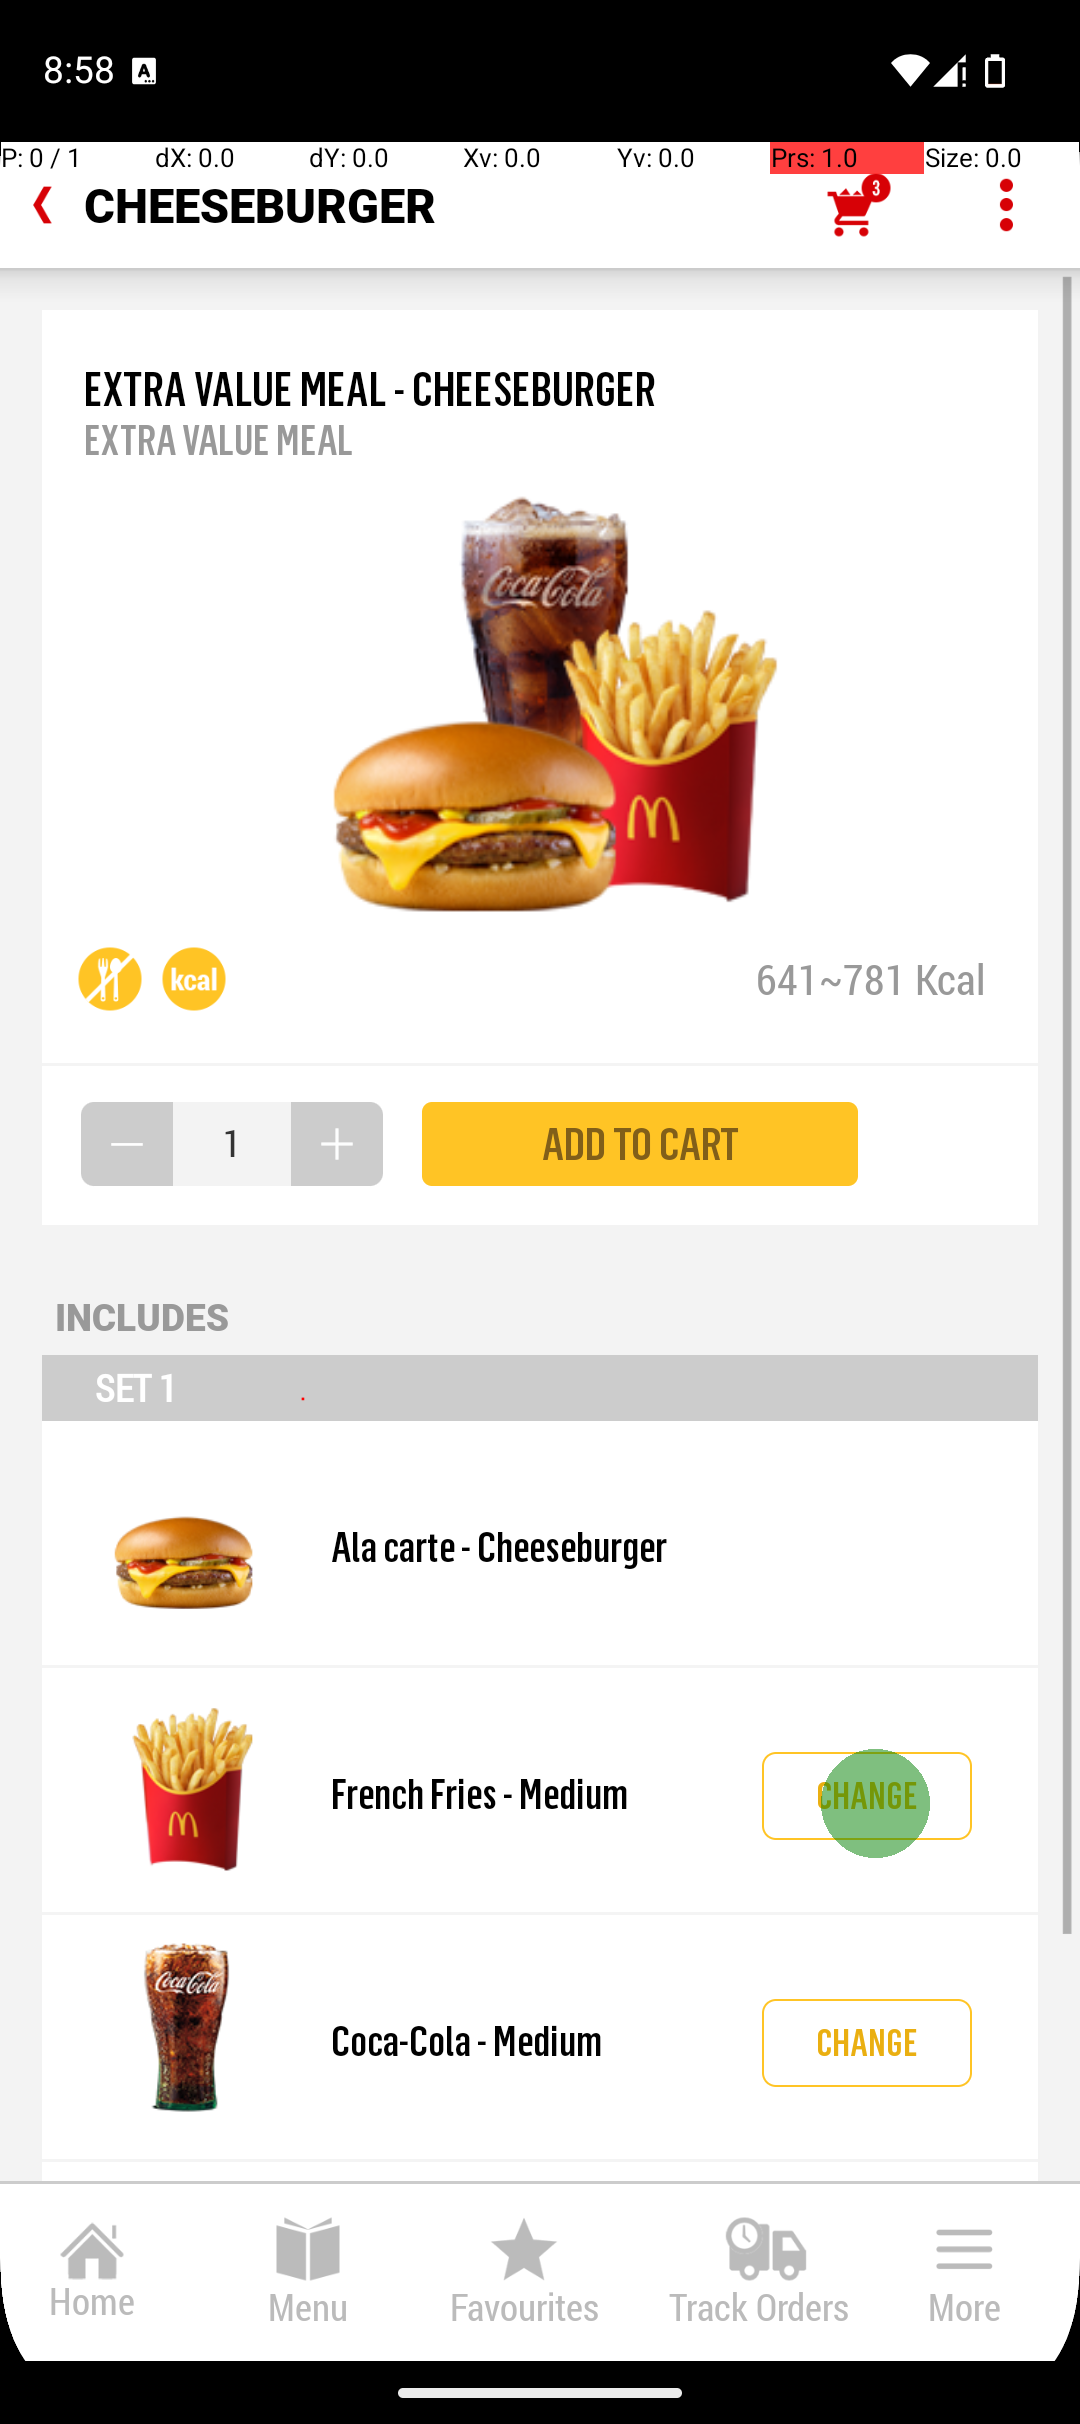

In [125]:
# Error case 1 special vs alacarte

screenshot = 'data/mcdonalds/93/93_7.png'

# user_query = '''
# The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function.
# Instruction: Choose large extra value meal with Bulgogi Burger, replace fries with coleslaw, and add to cart.
# Specific Action: Add to Cart
# '''
user_query = '''
Change drink to decaffeine iced americano
'''

# user_query = '''
# SelectBurger 'Cheeseburger'
# '''

# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
# actor(model7, screenshot, user_query)

In [ ]:
# Error case 1 special vs alacarte

screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/21/21_1.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function with the reason why you made that choice.
Instruction: Select Double 1955 Burger extra value meal and replace fries with coleslaw, then add to cart. 
Specific Action: SelectCategory 'specials'
'''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
# Error case 1

screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/21/21_1.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function.
Instruction: Select Double 1955 Burger extra value meal and replace fries with coleslaw, then add to cart. 
'''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
# Error case 1 with screen information

screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/21/21_1.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function.
Instruction: Select Double 1955 Burger extra value meal and replace fries with coleslaw, then add to cart. 
Screen Information: On the screen, there are areas to view special menus, ala carte menus, snack menus, beverages, desserts and happy meal
'''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/22/22_4.png'


user_query = '''
Select Change button coca cola to 'vanilla latte'
'''
# user_query = '''
# The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function.
# Instruction: Choose Double 1955 Burger large extra value meal, set drink to vanilla latte, and add to cart.
# Specific Action: ChangeDrink 'vanilla latte'
# '''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/22/22_4.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function.
Instruction: Choose Double 1955 Burger large extra value meal, set drink to vanilla latte, and add to cart.
Specific Action: ChangeDrink 'vanilla latte'
Screen Information: On the screen, there are areas to change the quantity, a section to add items to the cart, a button to change the side menu, and a button to change the drink.
'''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/22/22_4.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function with the reason why you made that choice.
Instruction: Choose Double 1955 Burger large extra value meal, set drink to vanilla latte, and add to cart.
Specific Action: ChangeDrink 'vanilla latte'
Screen Information: On the screen, there are areas to change the quantity, a section to add items to the cart, a button to change the side menu, and a button to change the drink.
'''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/22/22_4.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function with the reason why you made that choice.
Instruction: Choose Double 1955 Burger large extra value meal, set drink to vanilla latte, and add to cart.
Specific Action: ChangeDrink 'vanilla latte'
'''
# Task progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; 
# '''



actor(model3, screenshot, user_query)
actor(model7, screenshot, user_query)

In [ ]:
screenshot = '/home/ubuntu/mhchoi-arizona/mcdonalds/23/23_6.png'

user_query = '''
The user query: Here is the insturction and specific action for achieving given instruction. Return an appropriate function with the reason why you made that choice.
Instruction: Add Double 1955 Burger extra value meal with Shanghai chicken snack wrap as a side to the cart.
Specific Action: AddSide 'Shanghai chicken snack wrap'
'''
# Screen Information: On the screen, there are areas to change the quantity, a section to add items to the cart, a button to change the side menu, and a button to change the drink.
# '''




actor(model3, screenshot, user_query)
# actor(model7, screenshot, user_query)

In [ ]:
screenshot = 'mcdonalds/94_8.png'

# The operation history can be orgnized by Step x: [action]; Step x+1: [action]...
# user_query = 'The user query:  Open the file manager app and view the au_uu_SzH3yR2.mp3 file in MUSIC Folder\nTask progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; '
# user_query = 'The user query: Choose Cheeseburger, replace fries with coleslaw, and add to cart. To achieve this goal, SelectBurger \'Sandwich\'. \nTask progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; '
user_query = 'Choose large extra value meal with Cheeseburger, replace fries with coleslaw, and add to cart. \nTask progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; '

# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)
resized_height, resized_width  = smart_resize(dummy_image.height,
    dummy_image.width,
    factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
    min_pixels=processor.image_processor.min_pixels,
    max_pixels=processor.image_processor.max_pixels,)
mobile_use = MobileUse(
    cfg={"display_width_px": resized_width, "display_height_px": resized_height}
)

# Build messages
message = NousFnCallPrompt().preprocess_fncall_messages(
    messages = [
        Message(role="system", content=[ContentItem(text="You are a helpful assistant.")]),
        Message(role="user", content=[
            ContentItem(text=user_query),
            ContentItem(image=f"file://{screenshot}")
        ]),
    ],
    functions=[mobile_use.function],
    lang=None,
)
message = [msg.model_dump() for msg in message]

text = processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
print("text",text)
inputs = processor(text=[text], images=[dummy_image], padding=True, return_tensors="pt").to('cuda')


output_ids = model.generate(**inputs, max_new_tokens=2048)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
print('output text')
print(output_text)

# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])
print("\naction")
print(action)

# As an example, we visualize the "click" action by draw a green circle onto the image.
display_image = dummy_image.resize((resized_width, resized_height))
if action['arguments']['action'] == "click":
    display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(display_image)
else:
    display(display_image)